## MorphL Challenge - Mihaela Nistor

The dataset is divided in 3 parts: users, sessions and hits. The users contain unique user ids and some basic user-level features. Then, the sessions represent each unique visit of the user to the website and we also have session-level features (browser used at that session, session duration etc.). Finally, we have hits, which can be interpreted as session-specific actions (such as what page was viewed). Basically, we have an embedded dataset: users > sessions > hits.

Our task is to model the user behaviour based on its history in order to predict a user-level feature (segment). Obviously, this is a very open-ended problem, with solutions varying from the simplest models (as those in prerequisites) to much more complex models (such as modeling hits and sessions with RNNs).

In [1]:
# !sudo pip install imbalanced-learn

Import everything

In [2]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import imblearn
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_validate
from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Read the dataset

In [3]:
# train_users = pd.read_csv('./train_set/users.csv')
# train_sessions = pd.read_csv('./train_set/sessions.csv')
# train_hits = pd.read_csv('./train_set/hits.csv')

# train_targets = pd.read_csv('./train_set/targets.csv')


# test_users = pd.read_csv('./test_set/users.csv')
# test_sessions = pd.read_csv('./test_set/sessions.csv')
# test_hits = pd.read_csv('./test_set/hits.csv')

# test_targets = pd.read_csv('./test_set/targets.csv')

In [4]:
from google.colab import drive
drive.mount('/content/drive')


root_folder = '/content/drive/MyDrive/Colab Notebooks/dataset_morphl/'

train_users = pd.read_csv(root_folder + 'train_set/users.csv')
train_sessions = pd.read_csv(root_folder + 'train_set/sessions.csv')
train_hits = pd.read_csv(root_folder + 'train_set/hits.csv')

train_targets = pd.read_csv(root_folder + 'train_set/targets.csv')


test_users = pd.read_csv(root_folder + 'test_set/users.csv')
test_sessions = pd.read_csv(root_folder + 'test_set/sessions.csv')
test_hits = pd.read_csv(root_folder + 'test_set/hits.csv')

test_targets = pd.read_csv(root_folder + 'test_set/targets.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
print(train_users.shape)
train_users.head()

(11200, 4)


,Unnamed: 0,Client ID,Total Number of Sessions,Type
0,0,ML10669446,3,1
1,1,ML1054774,20,2
2,2,ML1023632,17,2
3,3,ML1050999,1,2
4,4,ML10421332,11,1


In [6]:
train_sessions.head()

,Unnamed: 0,Unnamed: 0.1,Client ID,Session ID,Session Index,Session Duration,Transactions,Revenue,Site Search Status,Search Result Page Hits,Unique Pageviews,Shopping Stages,Device Category,City Name,Country,Browser Name,Device Name,Search Refinements,Search Depth,Days Since Last Session,Results Pageviews,Total Unique Searches
0,0,0,ML1000002,1587635093.120043981.1559843616.20200423,1,164,0,0.0,Visit Without Site Search,0,3,0,desktop,City-151,Country-50,Browser-46,Device-0,0,0.0,0,0,0
1,1,1,ML10000104,1577964914.1347073935.1554187261.20200102,1,353,0,0.0,Visit Without Site Search,0,6,0,mobile,City-907,Country-50,Browser-4,Device-217,0,0.0,0,0,0
2,2,2,ML10000104,1577984613.1347073935.1554187261.20200102,2,64,0,0.0,Visit Without Site Search,0,3,0,mobile,City-907,Country-50,Browser-4,Device-217,0,0.0,0,0,0
3,3,3,ML10000104,1577997594.1347073935.1554187261.20200102,3,4,0,0.0,Visit Without Site Search,0,2,0,mobile,City-907,Country-50,Browser-4,Device-217,0,0.0,0,0,0
4,4,4,ML10000104,1580645789.1861233595.1580645788.20200202,4,45,0,0.0,Visit Without Site Search,0,5,0,mobile,City-135,Country-50,Browser-4,Device-502,0,0.0,30,0,0


In [7]:
train_hits.head()

,Unnamed: 0,Client ID,Session ID,Hit Index,Hit Time,Date Hour and Minute,Product Detail Views,Path of Page
0,0,ML1000002,1587635093.120043981.1559843616.20200423,2,19106,202004230945,0,URL-1327
1,1,ML1000002,1587635093.120043981.1559843616.20200423,3,164167,202004230947,0,URL-1351
2,2,ML1000002,1587635093.120043981.1559843616.20200423,1,0,202004230944,0,URL-14663
3,3,ML10000104,1580645789.1861233595.1580645788.20200202,4,16274,202002021216,0,URL-9880
4,4,ML10000104,1577984613.1347073935.1554187261.20200102,1,0,202001021703,0,URL-14320


In [8]:
train_users = train_users.drop(['Unnamed: 0'], axis=1)
test_users = test_users.drop(['Unnamed: 0'], axis=1)
train_sessions = train_sessions.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)
test_sessions = test_sessions.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)
train_hits = train_hits.drop(['Unnamed: 0'], axis=1)
test_hits = test_hits.drop(['Unnamed: 0'], axis=1)

In [9]:
train_targets.head()

,Unnamed: 0,Client ID,segment
0,0,ML73020059,1
1,1,ML10396280,0
2,2,ML1017227,0
3,3,ML10230015,0
4,4,ML73768914,1


Create dataset function that append the hits mean/meadian to the the session and the sessions mean/median to the client(user)

In [10]:
def create_dataset(users, sessions, hits, targets, method="mean"):
    """
        Create one DataFrame from the users info: sessions, hits, segment
    """

    # group the hits by the session id
    if method == "mean":
        hits = hits.groupby(['Session ID'], as_index=False).mean()
    else:
        hits = hits.groupby(['Session ID'], as_index=False).median()

    # add the hits to their session
    sessions  = sessions.join(hits.set_index('Session ID'), on='Session ID', lsuffix='_session', rsuffix='_hit')

    # group the sessions by the client id
    if method == "mean":
        sessions = sessions.groupby(['Client ID'], as_index=False).mean()
    else:
        sessions = sessions.groupby(['Client ID'], as_index=False).median()

    # add the sessions to their client
    users  = users.join(sessions.set_index('Client ID'), on='Client ID', lsuffix='_user', rsuffix='_session')

    # add the targets to their client
    users  = users.join(targets.set_index('Client ID'), on='Client ID', lsuffix='_user', rsuffix='_target')

    return users

In [11]:
train_data = create_dataset(train_users, train_sessions, train_hits, train_targets)
test_data = create_dataset(test_users, test_sessions, test_hits, test_targets)

print(train_data.shape)
print(test_data.shape)

(11200, 20)
(1000, 20)


In [12]:
train_data.head()

,Client ID,Total Number of Sessions,Type,Session Index,Session Duration,Transactions,Revenue,Search Result Page Hits,Unique Pageviews,Search Refinements,Search Depth,Days Since Last Session,Results Pageviews,Total Unique Searches,Hit Index,Hit Time,Date Hour and Minute,Product Detail Views,Unnamed: 0,segment
0,ML10669446,3,1,1.5,248.500000,0.0,0.0,0.000000,5.500000,0.0,0.000000,53.500000,0.000000,0.000000,7.500000,47624.229167,2.020041e+11,0.00,6237,0
1,ML1054774,20,2,9.5,830.388889,0.0,0.0,0.000000,5.444444,0.0,0.000000,2.944444,0.000000,0.000000,6.111111,427477.318289,2.020051e+11,0.00,4981,0
2,ML1023632,17,2,15.5,206.033333,0.0,0.0,0.000000,3.400000,0.0,0.000000,5.333333,0.000000,0.000000,4.250000,96655.143718,2.020035e+11,0.01,10503,0
3,ML1050999,1,2,7.0,614.000000,0.0,0.0,0.076923,3.846154,0.0,0.307692,7.076923,0.076923,0.076923,4.192308,252253.695688,2.020044e+11,0.00,783,0
4,ML10421332,11,1,2.0,20.000000,0.0,0.0,0.000000,1.333333,0.0,0.000000,3.000000,0.000000,0.000000,1.833333,11109.333333,2.020021e+11,0.00,3048,0


Use LabelEncoder to transform the 'Client ID' string to float value

In [13]:
le = LabelEncoder()
le.fit(pd.concat([train_data['Client ID'], test_data['Client ID']]).astype(str))
train_data['Client ID'] = le.transform(train_data['Client ID'].astype(str))
test_data['Client ID'] = le.transform(test_data['Client ID'].astype(str))
train_data.dtypes

Client ID                     int64
Total Number of Sessions      int64
Type                          int64
Session Index               float64
Session Duration            float64
Transactions                float64
Revenue                     float64
Search Result Page Hits     float64
Unique Pageviews            float64
Search Refinements          float64
Search Depth                float64
Days Since Last Session     float64
Results Pageviews           float64
Total Unique Searches       float64
Hit Index                   float64
Hit Time                    float64
Date Hour and Minute        float64
Product Detail Views        float64
Unnamed: 0                    int64
segment                       int64
dtype: object

Count if all values are finite

In [14]:
np.isfinite(train_data).sum()

Client ID                   11200
Total Number of Sessions    11200
Type                        11200
Session Index               11192
Session Duration            11192
Transactions                11192
Revenue                     11192
Search Result Page Hits     11192
Unique Pageviews            11192
Search Refinements          11192
Search Depth                11192
Days Since Last Session     11192
Results Pageviews           11192
Total Unique Searches       11192
Hit Index                   11192
Hit Time                    11192
Date Hour and Minute        11192
Product Detail Views        11192
Unnamed: 0                  11200
segment                     11200
dtype: int64

Replace infinite values with Nan

In [15]:
# replace inf with nan
train_data.replace([np.inf, -np.inf], np.nan)
test_data.replace([np.inf, -np.inf], np.nan)

,Client ID,Total Number of Sessions,Type,Session Index,Session Duration,Transactions,Revenue,Search Result Page Hits,Unique Pageviews,Search Refinements,Search Depth,Days Since Last Session,Results Pageviews,Total Unique Searches,Hit Index,Hit Time,Date Hour and Minute,Product Detail Views,Unnamed: 0,segment
0,7802,1,2,8.5,285.187500,0.0,0.0,0.000000,4.000000,0.000000,0.000000,10.437500,0.000000,0.000000,4.562500,8.321651e+04,2.020038e+11,0.012931,705,0.5
1,2263,3,2,33.5,562.651515,0.0,0.0,0.075758,1.818182,0.015152,0.151515,2.363636,0.045455,0.045455,2.856061,2.803967e+05,2.020038e+11,0.036105,710,0.5
2,6572,1,2,8.0,326.133333,0.0,0.0,0.000000,3.200000,0.000000,0.000000,7.733333,0.000000,0.000000,6.666667,1.517154e+05,2.020045e+11,0.087637,23,0.5
3,2523,19,2,16.5,415.656250,0.0,0.0,0.750000,4.750000,0.125000,1.093750,4.718750,0.406250,0.312500,4.750000,2.267386e+05,2.020042e+11,0.009868,800,0.5
4,6765,37,1,2.5,336.500000,0.0,0.0,0.000000,6.250000,0.000000,0.000000,36.250000,0.000000,0.000000,3.875000,5.621226e+04,2.020036e+11,0.000000,654,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,8062,1,9,1.0,3787.000000,0.0,0.0,0.000000,32.000000,0.000000,0.000000,0.000000,0.000000,0.000000,38.000000,2.144218e+06,2.020033e+11,0.000000,426,0.5
996,584,25,2,2.0,420.666667,0.0,0.0,0.000000,3.333333,0.000000,0.000000,24.000000,0.000000,0.000000,5.000000,1.063912e+05,2.020045e+11,0.000000,949,0.5
997,8791,8,9,2.5,86.000000,0.0,0.0,0.250000,2.750000,0.000000,0.000000,17.000000,0.000000,0.000000,2.250000,4.147883e+04,2.020049e+11,0.000000,494,0.5
998,3573,2,1,1.5,257.500000,0.0,0.0,0.000000,6.500000,0.000000,0.000000,0.000000,0.000000,0.000000,4.750000,1.356443e+05,2.020033e+11,0.000000,618,0.5


Count nan values

In [16]:
train_data.isna().sum()

Client ID                   0
Total Number of Sessions    0
Type                        0
Session Index               8
Session Duration            8
Transactions                8
Revenue                     8
Search Result Page Hits     8
Unique Pageviews            8
Search Refinements          8
Search Depth                8
Days Since Last Session     8
Results Pageviews           8
Total Unique Searches       8
Hit Index                   8
Hit Time                    8
Date Hour and Minute        8
Product Detail Views        8
Unnamed: 0                  0
segment                     0
dtype: int64

Remove data with nan values

In [17]:
train_data.dropna(inplace=True)
test_data.dropna(inplace=True)

train_data.isna().sum()

Client ID                   0
Total Number of Sessions    0
Type                        0
Session Index               0
Session Duration            0
Transactions                0
Revenue                     0
Search Result Page Hits     0
Unique Pageviews            0
Search Refinements          0
Search Depth                0
Days Since Last Session     0
Results Pageviews           0
Total Unique Searches       0
Hit Index                   0
Hit Time                    0
Date Hour and Minute        0
Product Detail Views        0
Unnamed: 0                  0
segment                     0
dtype: int64

In [18]:
test_data.isna().sum()

Client ID                   0
Total Number of Sessions    0
Type                        0
Session Index               0
Session Duration            0
Transactions                0
Revenue                     0
Search Result Page Hits     0
Unique Pageviews            0
Search Refinements          0
Search Depth                0
Days Since Last Session     0
Results Pageviews           0
Total Unique Searches       0
Hit Index                   0
Hit Time                    0
Date Hour and Minute        0
Product Detail Views        0
Unnamed: 0                  0
segment                     0
dtype: int64

See columns types

In [19]:
train_data.dtypes

Client ID                     int64
Total Number of Sessions      int64
Type                          int64
Session Index               float64
Session Duration            float64
Transactions                float64
Revenue                     float64
Search Result Page Hits     float64
Unique Pageviews            float64
Search Refinements          float64
Search Depth                float64
Days Since Last Session     float64
Results Pageviews           float64
Total Unique Searches       float64
Hit Index                   float64
Hit Time                    float64
Date Hour and Minute        float64
Product Detail Views        float64
Unnamed: 0                    int64
segment                       int64
dtype: object

In [20]:
train_data.head()

,Client ID,Total Number of Sessions,Type,Session Index,Session Duration,Transactions,Revenue,Search Result Page Hits,Unique Pageviews,Search Refinements,Search Depth,Days Since Last Session,Results Pageviews,Total Unique Searches,Hit Index,Hit Time,Date Hour and Minute,Product Detail Views,Unnamed: 0,segment
0,8625,3,1,1.5,248.500000,0.0,0.0,0.000000,5.500000,0.0,0.000000,53.500000,0.000000,0.000000,7.500000,47624.229167,2.020041e+11,0.00,6237,0
1,7061,20,2,9.5,830.388889,0.0,0.0,0.000000,5.444444,0.0,0.000000,2.944444,0.000000,0.000000,6.111111,427477.318289,2.020051e+11,0.00,4981,0
2,3417,17,2,15.5,206.033333,0.0,0.0,0.000000,3.400000,0.0,0.000000,5.333333,0.000000,0.000000,4.250000,96655.143718,2.020035e+11,0.01,10503,0
3,6629,1,2,7.0,614.000000,0.0,0.0,0.076923,3.846154,0.0,0.307692,7.076923,0.076923,0.076923,4.192308,252253.695688,2.020044e+11,0.00,783,0
4,5657,11,1,2.0,20.000000,0.0,0.0,0.000000,1.333333,0.0,0.000000,3.000000,0.000000,0.000000,1.833333,11109.333333,2.020021e+11,0.00,3048,0


In [21]:
test_data.head()

,Client ID,Total Number of Sessions,Type,Session Index,Session Duration,Transactions,Revenue,Search Result Page Hits,Unique Pageviews,Search Refinements,Search Depth,Days Since Last Session,Results Pageviews,Total Unique Searches,Hit Index,Hit Time,Date Hour and Minute,Product Detail Views,Unnamed: 0,segment
0,7802,1,2,8.5,285.187500,0.0,0.0,0.000000,4.000000,0.000000,0.000000,10.437500,0.000000,0.000000,4.562500,83216.512552,2.020038e+11,0.012931,705,0.5
1,2263,3,2,33.5,562.651515,0.0,0.0,0.075758,1.818182,0.015152,0.151515,2.363636,0.045455,0.045455,2.856061,280396.683224,2.020038e+11,0.036105,710,0.5
2,6572,1,2,8.0,326.133333,0.0,0.0,0.000000,3.200000,0.000000,0.000000,7.733333,0.000000,0.000000,6.666667,151715.383549,2.020045e+11,0.087637,23,0.5
3,2523,19,2,16.5,415.656250,0.0,0.0,0.750000,4.750000,0.125000,1.093750,4.718750,0.406250,0.312500,4.750000,226738.635647,2.020042e+11,0.009868,800,0.5
4,6765,37,1,2.5,336.500000,0.0,0.0,0.000000,6.250000,0.000000,0.000000,36.250000,0.000000,0.000000,3.875000,56212.258929,2.020036e+11,0.000000,654,0.5


Split the target from the user data

In [22]:
train_y = train_data['segment']
train_X = train_data.drop(['segment'], axis=1)

test_y = test_data['segment']
test_X = test_data.drop(['segment'], axis=1)


Normalize the data excepting the 'Client ID', because we need it to identify the client predicted segment

In [23]:

min_max_scaler = MinMaxScaler()

columns = []
for col in list(test_X.columns):
  if col != "Client ID":
    columns.append(col)

test_X.loc[:, columns] = min_max_scaler.fit_transform(test_X[columns])
train_X.loc[:, columns] = min_max_scaler.fit_transform(train_X[columns])


In [24]:
train_X.head()

,Client ID,Total Number of Sessions,Type,Session Index,Session Duration,Transactions,Revenue,Search Result Page Hits,Unique Pageviews,Search Refinements,Search Depth,Days Since Last Session,Results Pageviews,Total Unique Searches,Hit Index,Hit Time,Date Hour and Minute,Product Detail Views,Unnamed: 0
0,8625,0.000398,0.000,0.001815,0.032686,0.0,0.0,0.000000,0.133663,0.0,0.000000,0.604520,0.000000,0.000000,0.035036,0.014387,0.969579,0.000000,0.556925
1,7061,0.003777,0.125,0.030853,0.109534,0.0,0.0,0.000000,0.132013,0.0,0.000000,0.033271,0.000000,0.000000,0.026926,0.129755,0.980122,0.000000,0.444772
2,3417,0.003181,0.125,0.052632,0.027078,0.0,0.0,0.000000,0.071287,0.0,0.000000,0.060264,0.000000,0.000000,0.016058,0.029279,0.962415,0.009524,0.937852
3,6629,0.000000,0.125,0.021779,0.080956,0.0,0.0,0.005044,0.084539,0.0,0.008791,0.079965,0.009324,0.021978,0.015722,0.076537,0.972072,0.000000,0.069917
4,5657,0.001988,0.000,0.003630,0.002509,0.0,0.0,0.000000,0.009901,0.0,0.000000,0.033898,0.000000,0.000000,0.001946,0.003297,0.948210,0.000000,0.272167


Split the train data in train and validation

In [25]:
train_X, valid_X, train_y, valid_y = train_test_split(train_X, train_y, random_state=17)

Count the client in every class (segment 0 / 1)

In [26]:
def plot_labels(train_y):
  plot_sb = sb.countplot(train_y, label='segment', palette="Set1")

  count_datapoints_in_classes = train_y.value_counts(sort=False)
  classes = list(set(train_y))
  for cls in classes:
    print('Class %d: %d' % (cls, count_datapoints_in_classes[cls]))

Class 0: 6278
Class 1: 2116


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


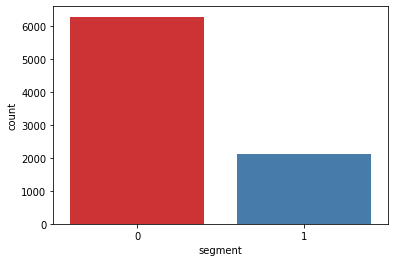

In [27]:
plot_labels(train_y)

Use SMOTE (Synthetic Minority Over-sampling TEchnique) to oversample the minority class 

In [28]:
oversample = SMOTE()
X_resampled, y_resampled = oversample.fit_resample(train_X, train_y)
train_X = pd.DataFrame(X_resampled, columns=train_X.columns)
train_y = pd.DataFrame(y_resampled, columns=['segment'])


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


See the number of values for every class after SMOTE

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Class 0: 6278
Class 1: 6278


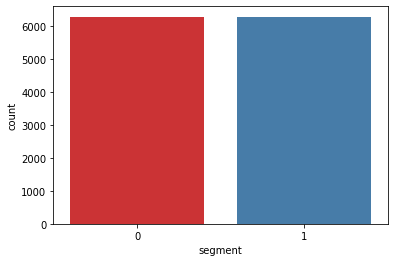

In [29]:
plot_labels(train_y['segment'])

Correlation map

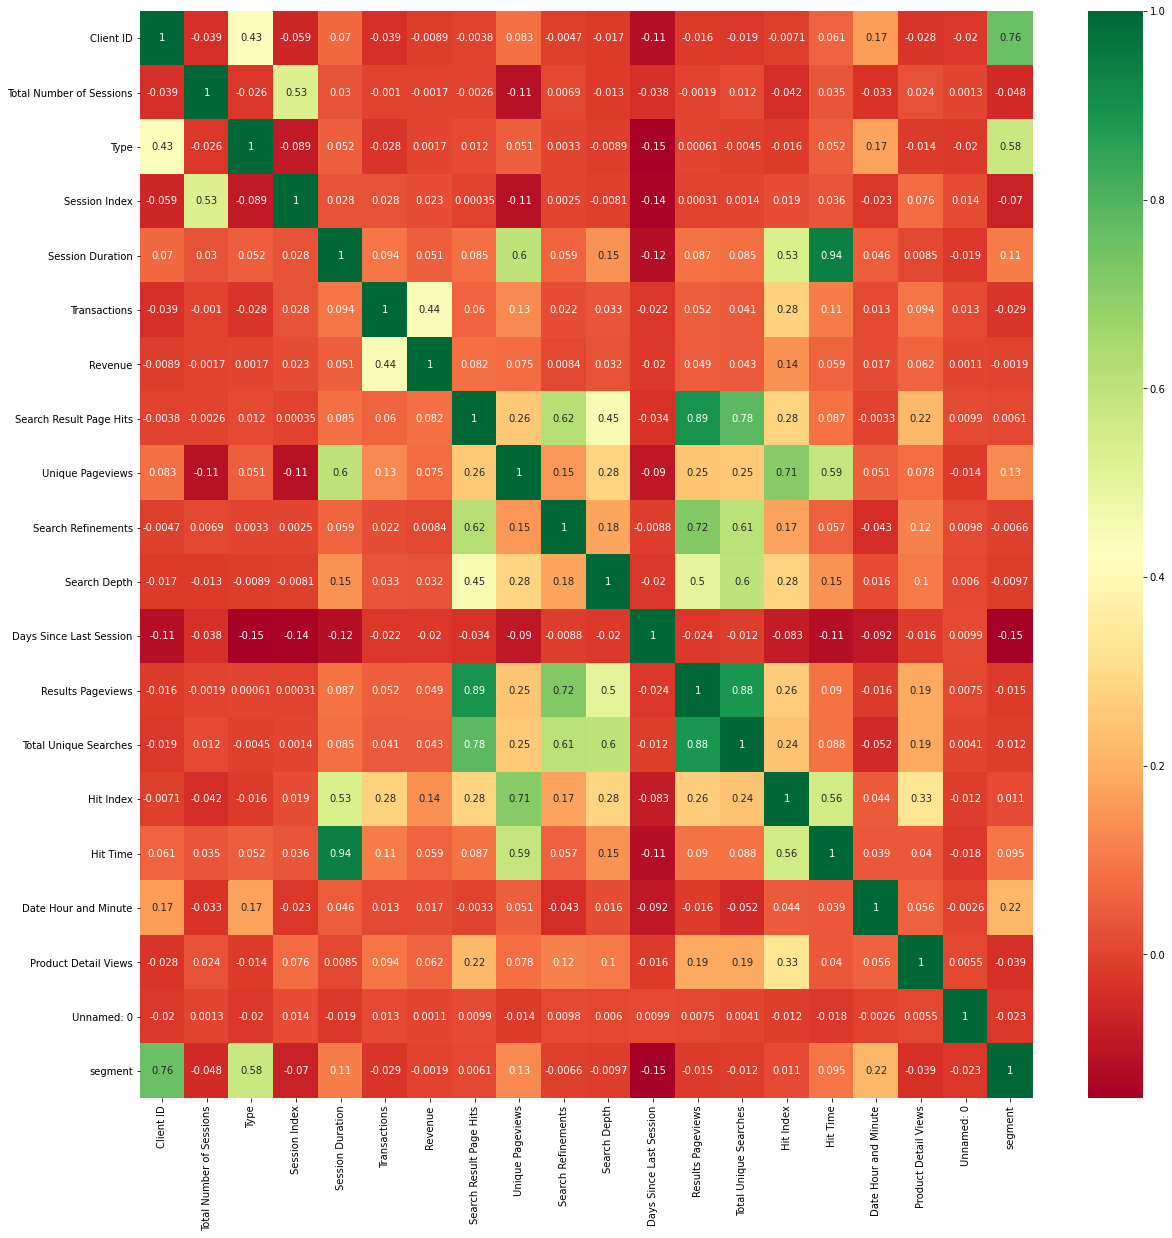

In [30]:
corrmat = train_data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g = sb.heatmap(train_data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

Find the best number of parameters

In [31]:
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
hyper_params = [{'n_features_to_select': list(range(1, len(train_X.columns)+1))}]

lm = RandomForestClassifier()
lm.fit(train_X, train_y.values.ravel())
rfe = RFE(lm)

model_cv = GridSearchCV(estimator = rfe, param_grid = hyper_params, scoring= 'r2', cv = folds, verbose = 1, return_train_score=True)

model_cv.fit(train_X, train_y.values.ravel())

cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

Fitting 5 folds for each of 19 candidates, totalling 95 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  95 out of  95 | elapsed: 14.2min finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,14.597969,0.194480,0.018858,0.000238,1,{'n_features_to_select': 1},0.996815,0.995215,0.993625,0.995220,0.996812,0.995537,0.001193,19,1.000000,1.000000,1.0,1.0,1.0,1.00000,0.000000
1,14.204330,0.156297,0.019502,0.000565,2,{'n_features_to_select': 2},1.000000,0.995215,0.998406,0.993626,0.996812,0.996812,0.002254,18,1.000000,1.000000,1.0,1.0,1.0,1.00000,0.000000
2,13.924907,0.194428,0.025031,0.007425,3,{'n_features_to_select': 3},1.000000,0.996810,0.998406,0.996813,0.998406,0.998087,0.001193,1,1.000000,1.000000,1.0,1.0,1.0,1.00000,0.000000
3,14.063604,1.290985,0.021962,0.002703,4,{'n_features_to_select': 4},1.000000,0.996810,0.998406,0.996813,0.998406,0.998087,0.001193,1,1.000000,1.000000,1.0,1.0,1.0,1.00000,0.000000
4,12.801812,0.195927,0.020390,0.000500,5,{'n_features_to_select': 5},1.000000,0.996810,0.998406,0.996813,0.998406,0.998087,0.001193,1,1.000000,1.000000,1.0,1.0,1.0,1.00000,0.000000
5,12.265555,0.106391,0.021791,0.000136,6,{'n_features_to_select': 6},1.000000,0.996810,0.998406,0.996813,0.998406,0.998087,0.001193,1,1.000000,1.000000,1.0,1.0,1.0,1.00000,0.000000
6,11.583232,0.105973,0.022556,0.000528,7,{'n_features_to_select': 7},1.000000,0.996810,0.998406,0.996813,0.998406,0.998087,0.001193,1,1.000000,1.000000,1.0,1.0,1.0,1.00000,0.000000
7,11.056293,0.129634,0.023761,0.000543,8,{'n_features_to_select': 8},1.000000,0.996810,0.998406,0.996813,0.998406,0.998087,0.001193,1,1.000000,1.000000,1.0,1.0,1.0,1.00000,0.000000
8,10.297742,0.148205,0.021704,0.000679,9,{'n_features_to_select': 9},1.000000,0.996810,0.998406,0.996813,0.998406,0.998087,0.001193,1,1.000000,1.000000,1.0,1.0,1.0,1.00000,0.000000
9,9.506326,0.168674,0.023957,0.001412,10,{'n_features_to_select': 10},1.000000,0.996810,0.998406,0.996813,0.998406,0.998087,0.001193,1,1.000000,1.000000,1.0,1.0,1.0,1.00000,0.000000


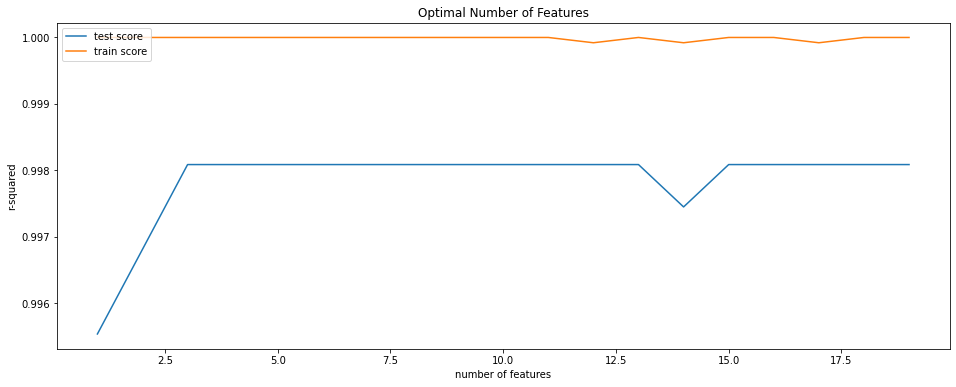

In [32]:
plt.figure(figsize=(16,6))
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')

Compute the features importance using cross validation

In [33]:
clf = RandomForestClassifier(n_estimators = 10, random_state = 42, class_weight="balanced")
output = cross_validate(clf, train_X, train_y.values.ravel(), cv = 2, scoring = 'accuracy', return_estimator =True)

for idx,estimator in enumerate(output['estimator']):
    print("Features sorted by their score for estimator {}:".format(idx))
    feature_importances = pd.DataFrame(estimator.feature_importances_, 
                                       index = train_X.columns,
                                       columns=['importance']).sort_values('importance', ascending=False)
    print(feature_importances)

Features sorted by their score for estimator 0:
                          importance
Client ID                   0.650173
Type                        0.196798
Date Hour and Minute        0.031856
Total Number of Sessions    0.027445
Days Since Last Session     0.019358
Unique Pageviews            0.014807
Session Index               0.014097
Hit Time                    0.013805
Session Duration            0.007108
Hit Index                   0.007044
Unnamed: 0                  0.005254
Product Detail Views        0.004645
Search Result Page Hits     0.003781
Results Pageviews           0.001489
Search Depth                0.000928
Search Refinements          0.000798
Total Unique Searches       0.000363
Transactions                0.000253
Revenue                     0.000000
Features sorted by their score for estimator 1:
                          importance
Client ID                   0.660949
Type                        0.210207
Date Hour and Minute        0.042636
Days Since Last 

Remove some of the features that do not bring any information to the model

In [34]:
train_X = train_X.drop(columns=['Revenue', 'Transactions', 'Search Refinements', 'Search Depth', 'Results Pageviews', 'Total Unique Searches', 'Product Detail Views'])
valid_X = valid_X.drop(columns=['Revenue', 'Transactions', 'Search Refinements', 'Search Depth', 'Results Pageviews', 'Total Unique Searches', 'Product Detail Views'])
test_X = test_X.drop(columns=['Revenue', 'Transactions', 'Search Refinements', 'Search Depth', 'Results Pageviews', 'Total Unique Searches', 'Product Detail Views'], axis=1)

In [35]:
def plot_confusion_matrix(y_valid, predictions):
    df_cm = confusion_matrix(y_valid, predictions)
    print(df_cm)
    df_cm = df_cm / df_cm.astype(np.float).sum(axis=1).sum()
    sb.heatmap(df_cm, annot=True)

Try logistic Regression

accuracy_score: 0.974 
log loss: 0.901 
[[1984   55]
 [  18  741]]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


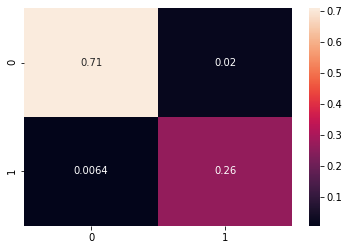

In [36]:
clf = LogisticRegression(C=0.1)
clf.fit(train_X, train_y)
predictions = clf.predict(valid_X)

print ("accuracy_score: %0.3f " % accuracy_score(valid_y, predictions))
print ("log loss: %0.3f " % log_loss(valid_y, predictions))
plot_confusion_matrix(valid_y, predictions)

Tune Logistic regression parameters with GridSearch

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best score: 0.990
Best parameters set:
	C: 10
	penalty: 'l2'
	solver: 'lbfgs'
accuracy_score: 0.990 
log loss: 0.333 
[[2019   20]
 [   7  752]]


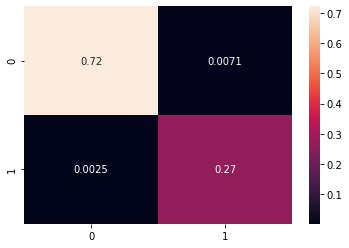

In [37]:
lr_model = LogisticRegression()

param_grid = {
    'C': [0.1, 1.0, 10],
    'penalty': ['l2'],  # 'elasticnet', 'none', 'l1'
    'solver': ['lbfgs']  # 'newton-cg', 'liblinear', 'sag', 'saga
}

model = GridSearchCV(lr_model, param_grid, return_train_score=True, cv=20, n_jobs=-1)

# Fit Grid Search Model
model.fit(train_X, train_y)
print("Best score: %0.3f" % model.best_score_)
print("Best parameters set:")

best_parameters = model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

predictions = model.predict(valid_X)

print ("accuracy_score: %0.3f " % accuracy_score(valid_y, predictions))
print ("log loss: %0.3f " % log_loss(valid_y, predictions))

# Best parameters set:
# 	C: 10
# 	penalty: 'l2'
# 	solver: 'lbfgs'

plot_confusion_matrix(valid_y, predictions)


Logistic regression with tuned params

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


accuracy_score: 0.990 
log loss: 0.333 
[[2019   20]
 [   7  752]]


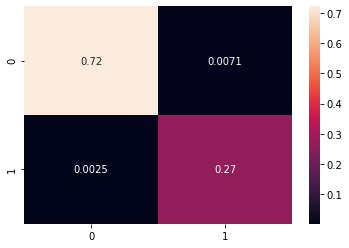

In [38]:
model = LogisticRegression(C=10, penalty='l2', solver='lbfgs')

model.fit(train_X, train_y)
predictions = model.predict(valid_X)

print ("accuracy_score: %0.3f " % accuracy_score(valid_y, predictions))
print ("log loss: %0.3f " % log_loss(valid_y, predictions))

plot_confusion_matrix(valid_y, predictions)

Predict the segment for the test value

In [39]:
predictions = model.predict_proba(test_X)
predictions = [i[1] for i in predictions]
print(predictions)


[0.9966777076507453, 6.6520997589476e-11, 0.037066914147819284, 4.266374579488101e-11, 0.18468497696748182, 0.9990272069299754, 1.3645237202530962e-05, 0.9999999999996863, 1.4028213428918414e-10, 0.9999999956448951, 0.9999999999070259, 2.2686857759776352e-08, 9.697322456647814e-14, 1.978109597167343e-12, 0.9996676930218649, 1.553364432227157e-09, 0.9930327740333539, 0.9999268027835635, 0.9999999999216693, 0.9999999999674374, 9.08439378742472e-12, 0.999952812550735, 4.334992159120735e-07, 0.00044014101795155416, 0.9999993581504661, 1.3836228338983426e-14, 0.9999999999948206, 0.9999975385549686, 2.649138605373201e-05, 0.9999999995041384, 0.035570610919896106, 0.9999999996791962, 0.9999999994187994, 0.021397952850672856, 0.9980565995057614, 0.5730351158576485, 0.9999987638968232, 3.3046434497227e-11, 0.9999828191609663, 5.014403013002396e-16, 0.949816054610727, 0.9999959290067227, 0.00458005207043006, 0.5916005707823462, 0.9999940390544635, 0.9999949192797504, 6.738210302202548e-07, 0.999

Save the predictions

In [40]:
# test_X['segment'] = predictions
# test_targets = test_targets.drop(['segment'], axis=1)
# test_X['Client ID'] = le.inverse_transform(test_X['Client ID'])

# test_targets = pd.merge(test_targets,test_X[['Client ID','segment']],on='Client ID') 
# test_targets.to_csv(index=False, path_or_buf=root_folder +'logistic_regression_results_prob2.csv')